# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.core.display import display, HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# impute.imputer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA
# stats : R module
from scipy.stats import skew, kurtosis

# estimators ---------------------------------------
# estimators.classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV # regressor 응용
# estimators.regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
# --------------------------------------------------

# neural network -----------------------------------
import tensorflow as tf
import keras
# --------------------------------------------------

# ensemble -----------------------------------------
# ensemble.bagging
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# ensemble.boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
# ensemble.boosting & bagging
from xgboost import XGBRFClassifier, XGBRFRegressor
# ensemble.voting
from sklearn.ensemble import VotingClassifier, VotingRegressor
# --------------------------------------------------

# metrics ------------------------------------------
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# --------------------------------------------------

# model_selection ----------------------------------
# model_selection.splitter
from sklearn.model_selection import train_test_split
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV
# --------------------------------------------------

# optuna -------------------------------------------
import optuna
# --------------------------------------------------

# read

In [3]:
cus   = pd.read_csv('./cus_info.csv')
iem   = pd.read_csv('./iem_info_20210902.csv')
hist  = pd.read_csv('./stk_bnc_hist.csv')
train = pd.read_csv('./stk_hld_train.csv')
test  = pd.read_csv('./stk_hld_test.csv')
sub   = pd.read_csv('./sample_submission.csv')

# EDA

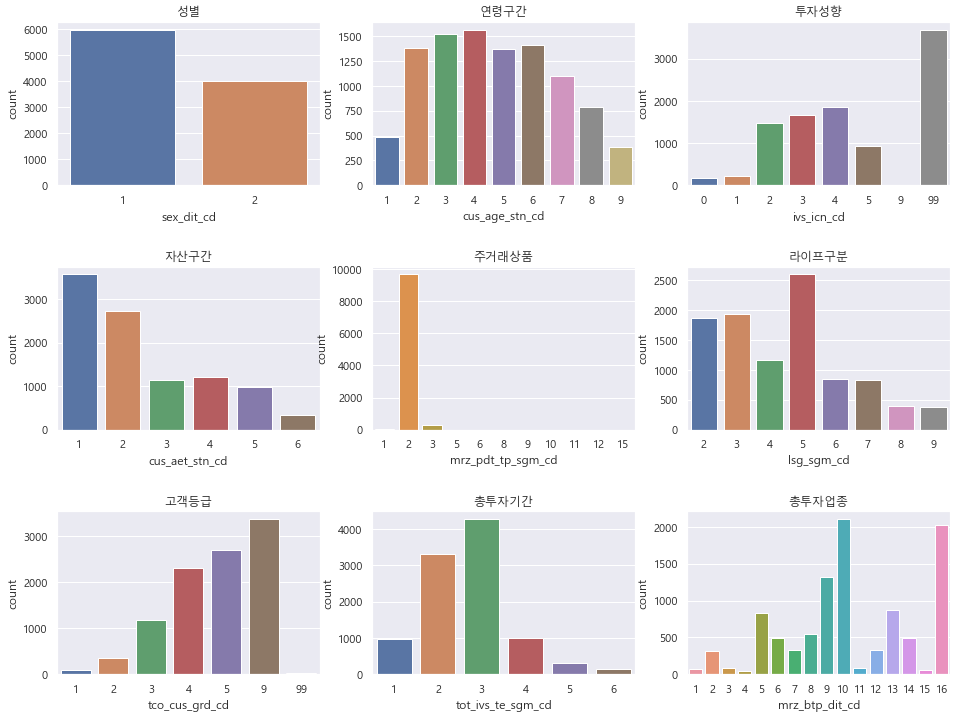

In [4]:
cus_cols = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']
cols     = ['성별', '연령구간', '투자성향', '자산구간', '주거래상품', '라이프구분', '고객등급', '총투자기간', '총투자업종']    

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols):
    r = i // 3
    c = i % 3
    sns.countplot(col, data=cus, ax=ax[r, c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

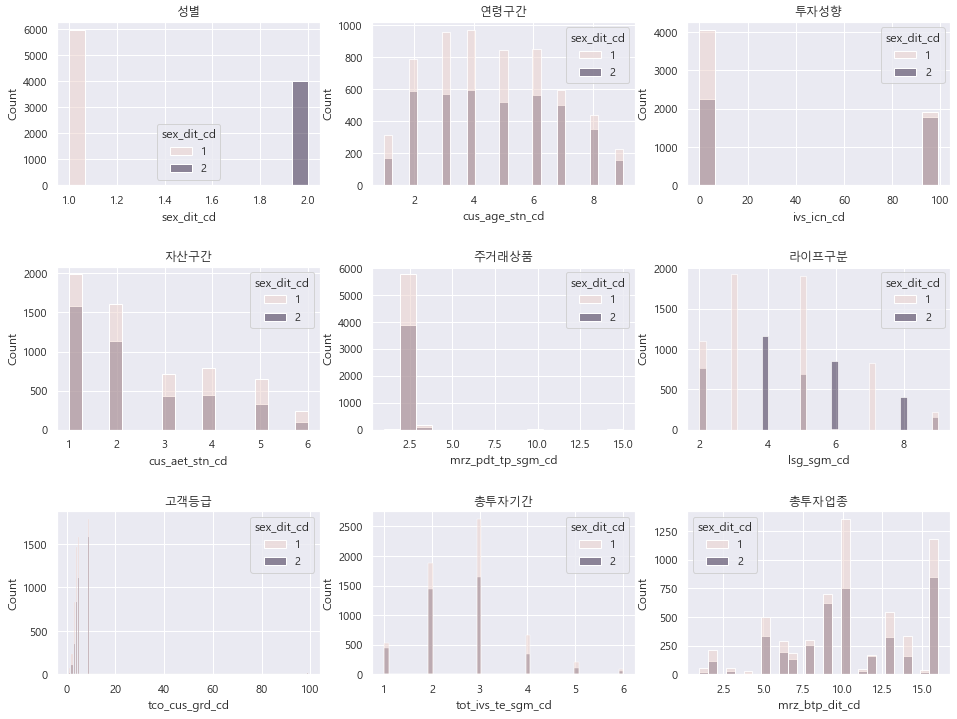

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols) :
    r = i // 3
    c = i % 3
    sns.histplot(data=cus, x=col, hue='sex_dit_cd', ax=ax[r ,c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# feature engineering

## cus.ivs_icn_cd : 투자성향

In [6]:
# 투자성향 미정의(99) 비율 0.3687 : drop
print(cus[cus['ivs_icn_cd'] == 99].shape[0] / cus.shape[0])
cus.drop('ivs_icn_cd', axis=1, inplace=True)

0.3687


## cus.lsg_sgm_cd : life stage

In [7]:
# 연령과 성별 변수 포함 : drop
cus.drop('lsg_sgm_cd', axis=1, inplace=True)

## cus.tco_cus_grd_cd : 서비스 등급

In [8]:
cus['tco_cus_grd_cd'][cus['tco_cus_grd_cd'] == 99] = 9

<AxesSubplot:>

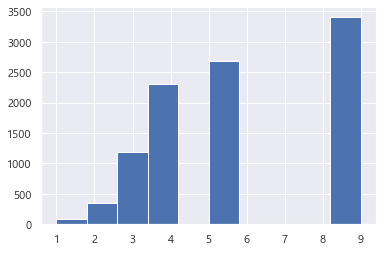

In [9]:
cus['tco_cus_grd_cd'].hist()

## hist.stk_p : 매매 평균단가

In [10]:
hist['stk_p'] = hist['tot_aet_amt'] / hist['bnc_qty']
hist['stk_p'].fillna(0, inplace=True)

## train.hist_d

In [11]:
train['hist_d'] = train['hold_d'] * 0.7

# merge

## cus & iem

In [12]:
train_data = pd.merge(train, cus, how='left', on='act_id')
train_data = pd.merge(train_data, iem, how='left', on='iem_cd')

test_data = pd.merge(test, cus, how='left', on='act_id')
test_data = pd.merge(test_data, iem, how='left', on='iem_cd')

## hist

In [13]:
train_data = pd.merge(train_data, hist, how='left', on=['act_id', 'iem_cd'])
train_data = train_data[(train_data['byn_dt'] == train_data['bse_dt'])]

test_data = pd.merge(test_data, hist, how = 'left', on=['act_id', 'iem_cd'])
test_data = test_data[(test_data['byn_dt'] == test_data['bse_dt'])]

In [14]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# encode

In [15]:
le = LabelEncoder()
le.fit(iem['iem_krl_nm'])
train_data['iem_krl_nm'] = le.transform(train_data['iem_krl_nm'])
test_data['iem_krl_nm']  = le.transform(test_data['iem_krl_nm'])

# drop

In [16]:
train_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt'], axis=1, inplace=True)
test_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'submit_id', 'hold_d'], axis=1, inplace=True)

In [17]:
train_data.shape, test_data.shape

((681472, 17), (70596, 16))

## scale

In [18]:
mm = MinMaxScaler()

mm.fit(train_data[test_data.columns])
train_data[test_data.columns] = mm.transform(train_data[test_data.columns])
test_data[test_data.columns]  = mm.transform(test_data[test_data.columns])

In [19]:
train_data['hold_d'] = np.log1p(train_data['hold_d'])

# score

In [20]:
X_train_data = train_data.drop('hold_d', axis=1)
y_train_data = train_data['hold_d']

In [21]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(X_train_data):
    
    train_x = X_train_data.iloc[train_idx, :]
    train_y = y_train_data[train_idx]
    val_x = X_train_data.iloc[val_idx, :]
    val_y = y_train_data[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=1)
    
    models.append(model)

[1]	valid_0's rmse: 1.32261	valid_0's l2: 1.7493
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 1.30942	valid_0's l2: 1.71457
[3]	valid_0's rmse: 1.29635	valid_0's l2: 1.68053
[4]	valid_0's rmse: 1.28342	valid_0's l2: 1.64716
[5]	valid_0's rmse: 1.27062	valid_0's l2: 1.61446
[6]	valid_0's rmse: 1.25794	valid_0's l2: 1.58242
[7]	valid_0's rmse: 1.24539	valid_0's l2: 1.551
[8]	valid_0's rmse: 1.23297	valid_0's l2: 1.52022
[9]	valid_0's rmse: 1.22067	valid_0's l2: 1.49004
[10]	valid_0's rmse: 1.2085	valid_0's l2: 1.46047
[11]	valid_0's rmse: 1.19644	valid_0's l2: 1.43147
[12]	valid_0's rmse: 1.18451	valid_0's l2: 1.40307
[13]	valid_0's rmse: 1.17269	valid_0's l2: 1.37521
[14]	valid_0's rmse: 1.161	valid_0's l2: 1.34792
[15]	valid_0's rmse: 1.14942	valid_0's l2: 1.32117
[16]	valid_0's rmse: 1.13796	valid_0's l2: 1.29494
[17]	valid_0's rmse: 1.12661	valid_0's l2: 1.26924
[18]	valid_0's rmse: 1.11537	valid_0's l2: 1.24406
[19]	valid_0's rmse: 1.10425	valid_

In [23]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis=0)

In [24]:
sub['hold_d'] = np.expm1(predict)

In [29]:
sub

,submit_id,hold_d
0,IDX00001,218.986825
1,IDX00002,479.502535
2,IDX00003,198.815780
3,IDX00004,336.680746
4,IDX00005,12.999923
...,...,...
70591,IDX70592,32.999573
70592,IDX70593,147.088076
70593,IDX70594,791.573546
70594,IDX70595,15.999862


In [ ]:
sub.to_csv('./sub15.csv', index=False) # sub_pjh_00.csv